/Users/jacksonsong/anaconda3/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/jacksonsong/anaconda3/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/jacksonsong/anaconda3/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/jacksonsong/anaconda3/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is

SPY - Actual Annual Return: -1.4087832790324106%, Predicted Annual Return: 1.1638964526355267%
SPY - Actual Annual Risk: 18.785344002935645%, Predicted Annual Risk: 5.768224596977234%
DIA - Actual Annual Return: -2.325432404421174%, Predicted Annual Return: 1.1638964526355267%
DIA - Actual Annual Risk: 15.66442189590541%, Predicted Annual Risk: 5.768224596977234%
QQQ - Actual Annual Return: 3.7211916130848346%, Predicted Annual Return: 1.1638964526355267%
QQQ - Actual Annual Risk: 25.337179999241844%, Predicted Annual Risk: 5.768224596977234%
IWM - Actual Annual Return: -11.34718852915914%, Predicted Annual Return: 1.1638964526355267%
IWM - Actual Annual Risk: 23.487428002396175%, Predicted Annual Risk: 5.768224596977234%
URTH - Actual Annual Return: -2.4602977887510757%, Predicted Annual Return: 1.1638964526355267%
URTH - Actual Annual Risk: 18.049968908084292%, Predicted Annual Risk: 5.768224596977234%
EEM - Actual Annual Return: -9.185439210427065%, Predicted Annual Return: 1.163896

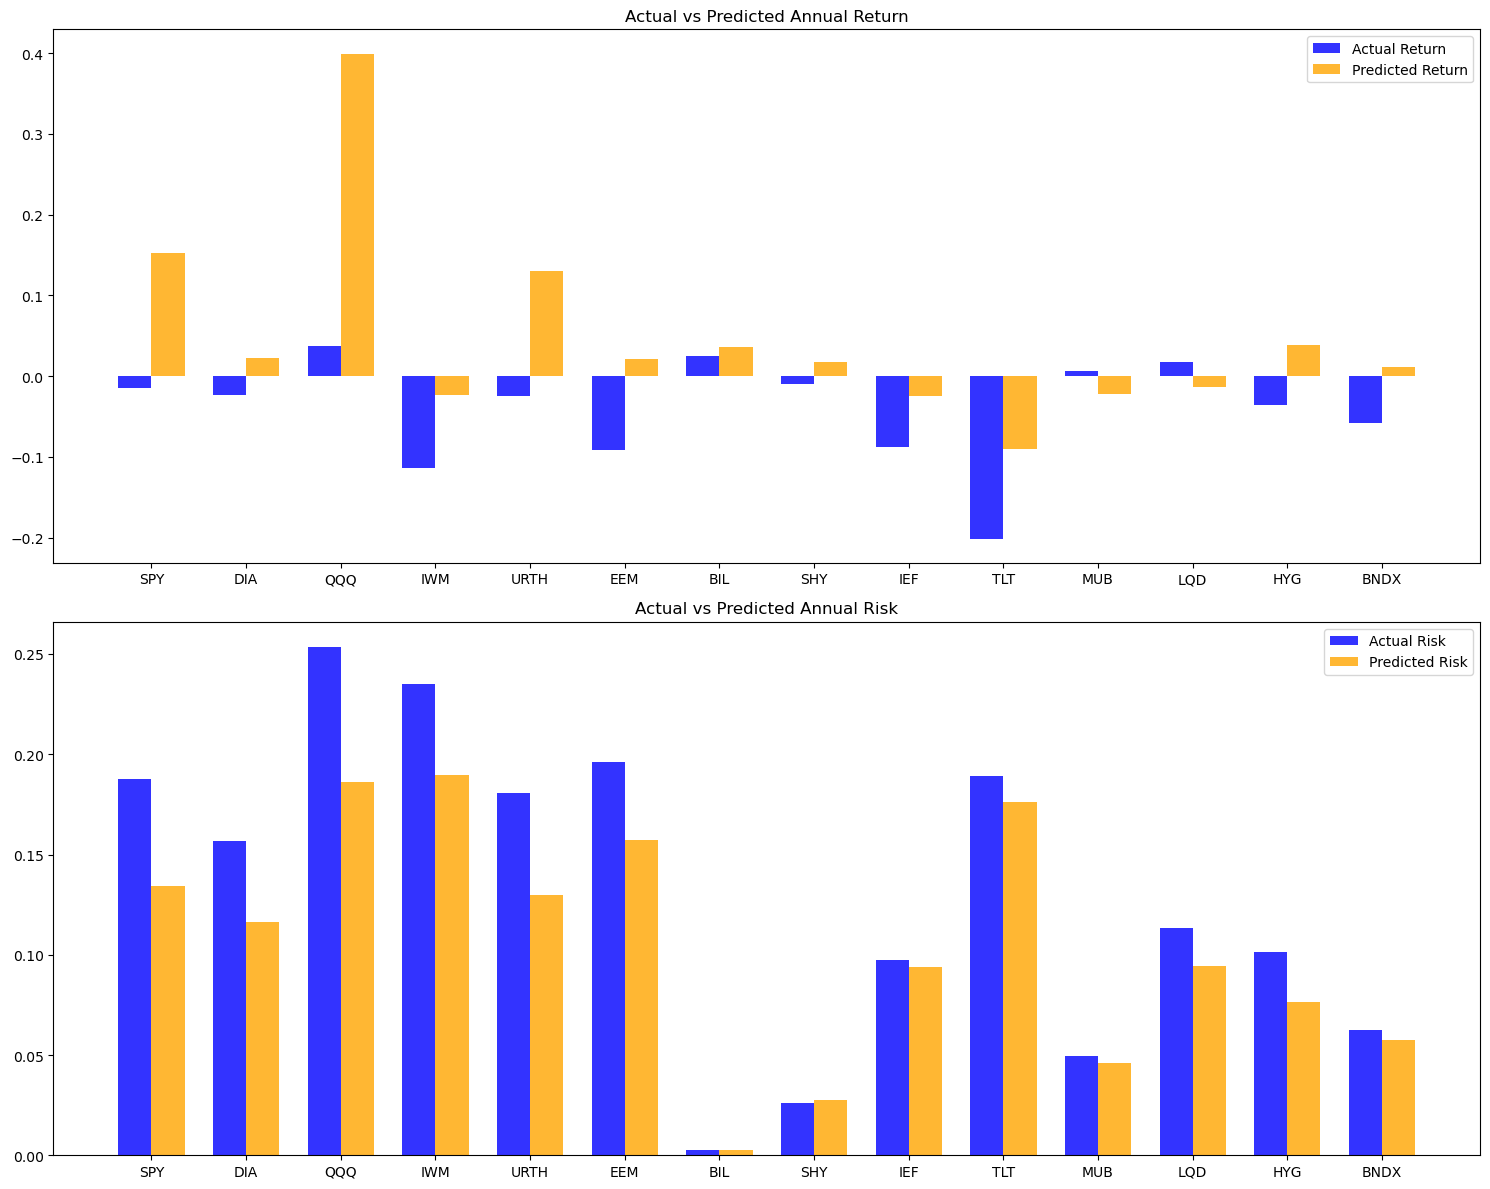

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.972318499855884
            Iterations: 15
            Function evaluations: 240
            Gradient evaluations: 15
Expected Portfolio Return: 3.38%
Expected Portfolio Risk: 0.85%
Optimal Portfolio Composition:
Invest 0.12% of funds in SPY
Invest 0.00% of funds in DIA
Invest 1.71% of funds in QQQ
Invest 0.00% of funds in IWM
Invest 0.00% of funds in URTH
Invest 0.00% of funds in EEM
Invest 50.00% of funds in BIL
Invest 48.17% of funds in SHY
Invest 0.00% of funds in IEF
Invest 0.00% of funds in TLT
Invest 0.00% of funds in MUB
Invest 0.00% of funds in LQD
Invest 0.00% of funds in HYG
Invest 0.00% of funds in BNDX


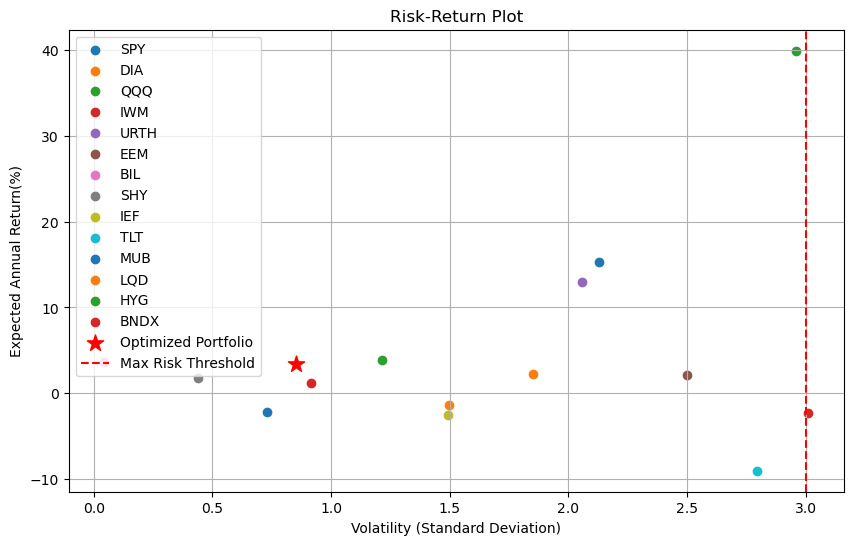

In [1]:
import pandas as pd
import os
import numpy as np
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from scipy.optimize import minimize




# Define the ticker symbols
index_funds = ['SPY', 'DIA', 'QQQ', 'IWM', 'URTH', 'EEM']
bond_types = ['BIL', 'SHY', 'IEF', 'TLT', 'MUB']
additional_bonds = ['LQD', 'HYG', 'BNDX']
all_tickers = index_funds + bond_types + additional_bonds




# Define the maximum allowed risk
max_risk = 3 # Adjust this value in terms of percentages
max_investment = 0.5 #Adjust this value as a decimal




# Initialize DataFrame to store annual metrics
annual_metrics_df = pd.DataFrame()


# Process data for each ticker
for ticker in all_tickers:
    csv_file = f"{ticker}.csv"
    if not os.path.exists(csv_file):
        print(f"CSV file for {ticker} not found. Skipping.")
        continue


    data = pd.read_csv(csv_file, parse_dates=['Date'], index_col='Date')
    data['Actual Daily Return'] = data['Adj Close'].pct_change()


    # Calculate annual return and risk
    annual_return = (1 + data['Actual Daily Return']).resample('Y').prod() - 1
    annual_risk = data['Actual Daily Return'].resample('Y').std() * np.sqrt(252)


    # Store in DataFrame
    annual_metrics_df[f'{ticker}_Annual Return'] = annual_return
    annual_metrics_df[f'{ticker}_Annual Risk'] = annual_risk


# Drop rows with NaN values
annual_metrics_df.dropna(inplace=True)


# Normalize the data
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(annual_metrics_df)
X_normalized = pd.DataFrame(X_normalized, columns=annual_metrics_df.columns)


# Time Series Cross-Validation
tscv = TimeSeriesSplit(n_splits=5)


# Initialize DataFrames for storing predicted metrics
predicted_returns_df = pd.DataFrame()
predicted_risk_df = pd.DataFrame()


# Model Training and Prediction
for ticker in all_tickers:
    # Prepare data for the ticker
    X = X_normalized[[f'{ticker}_Annual Return', f'{ticker}_Annual Risk']]
    y_return = annual_metrics_df[f'{ticker}_Annual Return']
    y_risk = annual_metrics_df[f'{ticker}_Annual Risk']


    # Check if X, y_return, y_risk are not empty
    if X.empty or y_return.empty or y_risk.empty:
        print(f"Data for {ticker} is empty. Skipping.")
        continue


    # Model for Returns
    model_return = XGBRegressor(objective='reg:squarederror')
    model_return.fit(X, y_return)
    future_return = model_return.predict(X.tail(1))


    # Model for Risk
    model_risk = XGBRegressor(objective='reg:squarederror')
    model_risk.fit(X, y_risk)
    future_risk = model_risk.predict(X.tail(1))


    # Store predicted metrics
    predicted_returns_df.loc[ticker, 'Predicted Annual Return'] = future_return[0]
    predicted_risk_df.loc[ticker, 'Predicted Risk'] = future_risk[0]


# Visualize Predictions
fig, axs = plt.subplots(2, 1, figsize=(15, 12))
bar_width = 0.35  # Width of the bars
opacity = 0.8  # Opacity of the bars


# Indices for the tickers
index = np.arange(len(all_tickers))


# Plot for Returns
for i, ticker in enumerate(all_tickers):
    axs[0].bar(index[i] - bar_width/2, annual_metrics_df[f'{ticker}_Annual Return'].mean(), bar_width, alpha=opacity, color='blue', label='Actual Return' if i == 0 else "")
    axs[0].bar(index[i] + bar_width/2, predicted_returns_df.loc[ticker, 'Predicted Annual Return'], bar_width, alpha=opacity, color='orange', label='Predicted Return' if i == 0 else "")
axs[0].set_title('Actual vs Predicted Annual Return')
axs[0].set_xticks(index)
axs[0].set_xticklabels(all_tickers)
axs[0].legend()


# Plot for Risk
for i, ticker in enumerate(all_tickers):
    # Print actual vs predicted values
    print(f"{ticker} - Actual Annual Return: {100*annual_metrics_df[f'{ticker}_Annual Return'].mean()}%, Predicted Annual Return: {100*future_return[0]}%")
    print(f"{ticker} - Actual Annual Risk: {100*annual_metrics_df[f'{ticker}_Annual Risk'].mean()}%, Predicted Annual Risk: {100*future_risk[0]}%")
    axs[1].bar(index[i] - bar_width/2, annual_metrics_df[f'{ticker}_Annual Risk'].mean(), bar_width, alpha=opacity, color='blue', label='Actual Risk' if i == 0 else "")
    axs[1].bar(index[i] + bar_width/2, predicted_risk_df.loc[ticker, 'Predicted Risk'], bar_width, alpha=opacity, color='orange', label='Predicted Risk' if i == 0 else "")
axs[1].set_title('Actual vs Predicted Annual Risk')
axs[1].set_xticks(index)
axs[1].set_xticklabels(all_tickers)
axs[1].legend()
plt.tight_layout()
plt.show()




predicted_metrics_df = pd.DataFrame(index=all_tickers)
predicted_metrics_df['Predicted Annual Return'] = predicted_returns_df['Predicted Annual Return']
predicted_metrics_df['Predicted Risk'] = predicted_risk_df['Predicted Risk']


# Calculate the daily returns for covariance matrix
daily_returns = pd.DataFrame()
for ticker in all_tickers:
    csv_file = f"{ticker}.csv"
    if os.path.exists(csv_file):
        data = pd.read_csv(csv_file, parse_dates=['Date'], index_col='Date')
        daily_returns[ticker] = data['Adj Close'].pct_change()




# Calculate the covariance matrix for the tickers
cov_matrix = daily_returns.cov() * 252  # Annualize the covariance matrix


# Define the objective function for MPT (Maximize Sharpe Ratio)
def objective(weights):
    portfolio_return = np.dot(weights, predicted_metrics_df['Predicted Annual Return'])
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return -portfolio_return / portfolio_volatility


# Bounds for each weight to be between 0 and 1
bounds = tuple((0, 1) for _ in predicted_metrics_df.index)


# Initial weights
initial_weights = np.array([1. / len(predicted_metrics_df)] * len(predicted_metrics_df))


# Constraints
def risk_constraint(weights):
    portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return max_risk - portfolio_risk


def max_investment_constraint(weights):
    return max_investment - max(weights)


# Add these constraints to the existing constraints tuple
constraints = (
    {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},
    {'type': 'ineq', 'fun': risk_constraint},
    {'type': 'ineq', 'fun': max_investment_constraint}
)


# Perform the optimization
solution = minimize(
    objective,
    initial_weights,
    method='SLSQP',
    constraints=constraints,
    bounds=bounds,
    options={'maxiter': 1000, 'disp': True}
)


# Check if the optimization was successful
if not solution.success:
    raise ValueError("Optimization failed:", solution.message)


# Extract the optimal asset weights
optimal_weights = solution.x


# Calculate the expected portfolio return and risk using the optimal weights
expected_return = 100 * np.dot(optimal_weights, predicted_metrics_df['Predicted Annual Return'])
expected_risk = 100 * np.sqrt(np.dot(optimal_weights.T, np.dot(cov_matrix, optimal_weights)))


# Print the expected portfolio return and risk
print(f"Expected Portfolio Return: {expected_return:.2f}%")
print(f"Expected Portfolio Risk: {expected_risk:.2f}%")
print("Optimal Portfolio Composition:")
for i, ticker in enumerate(predicted_metrics_df.index):
    weight = optimal_weights[i] * 100  # Convert to percentage
    print(f"Invest {weight:.2f}% of funds in {ticker}")

# Plotting individual stocks/bonds
plt.figure(figsize=(10, 6))
for ticker in predicted_metrics_df.index:
    plt.scatter(predicted_metrics_df.loc[ticker, 'Predicted Risk'] * np.sqrt(252),  # Annualized Risk
                predicted_metrics_df.loc[ticker, 'Predicted Annual Return'] * 100,  # Annualized Return
                label=ticker)


# Plotting the optimized portfolio
plt.scatter(expected_risk, expected_return, color='red', marker='*', s=150, label='Optimized Portfolio')


# Adding a vertical line for maximum risk
plt.axvline(x=max_risk, color='red', linestyle='--', label='Max Risk Threshold')


# Enhancements
plt.title('Risk-Return Plot')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Annual Return(%)')
plt.legend(loc='best')
plt.grid(True)


# Show the plot
plt.show()

